In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.jet()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<Figure size 640x480 with 0 Axes>

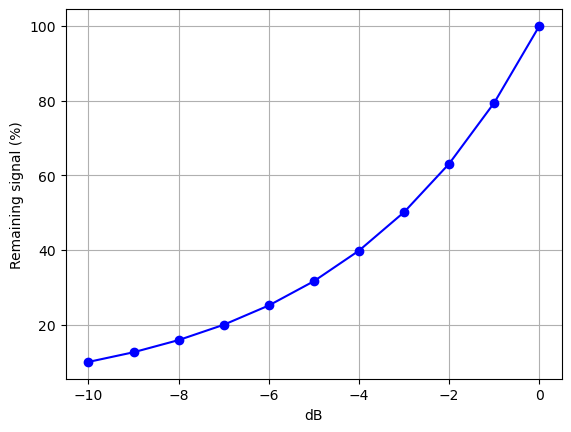

In [2]:
dB = np.arange(-10,1,1)
def dB2f(ddb):
    return 10**(ddb*0.1)
def f2dB(ff):
    return np.log10(ff)*10
frac = dB2f(dB)
plt.plot(dB, frac*100, '-bo')
plt.xlabel('dB')
plt.ylabel('Remaining signal (%)')
plt.grid();

In [3]:
#Attocube reflects 4% at FC/PC fiber end.
f2dB(.96), f2dB(.95), dB2f(-0.25), f2dB(4./96)

(-0.17728766960431602,
 -0.22276394711152253,
 0.9440608762859234,
 -13.802112417116062)

Looking at Attocube tech note 25

In [4]:
1000*0.1/180*np.pi

1.7453292519943295

## LASER BEAM SCATTERING IN  THE ATMOSPHERE

Science & Global Security, 1990, Volume 2, pp.79-86

There are two main mechanisms by which a laser beam propagating through the atmosphere is scattered: Rayleigh scattering by individual molecules and scattering by aerosols (small particles suspended in the atmosphere).

In [5]:
f2dB(0.5)

-3.010299956639812

In [6]:
#rayleigh scattering is negligible.
x = 2*23e-3 #because beta is in km^-1
beta = 2.5e-4 #estimated from Table 1 in paper above.
f2dB(np.exp(-beta*x))

-4.994386541899266e-05

In [7]:

#aerosol extinction at 5km altitude
x = 2*23e-3 #because beta is in km^-1
beta = 3.3e-3 #estimated from Table 1 in paper above.
print(f2dB(np.exp(-beta*x)))

#based on another paper: Fifteenth ARM Science Team Meeting Proceedings, Daytona Beach, Florida, March 14-18, 2005
#worst case, near ground, it gets to up to 0.34 for 0.55 micron wavelength.
#according to the 5km altitude table, the extinction coefficient gets smaller with longer wavelength.
x = 2*23e-3 #because beta is in km^-1
beta = 3e-1 #estimated from Table 1 in paper above.
print(f2dB(np.exp(-beta*x)))

-0.000659259023529354
-0.05993263850264872


## Moving onto the misalignment

In [31]:
linetype = 'LMT-A-M1-M2'
linetype = 'LMT-A-M1-M1'
#linetype = 'LMT-A-M2-M2'

linetype = 'LMT-D-M2-M2'
#linetype = 'LMT-D-M1-M1'

wavelen = 1550 #nm

#numerical simulation parameters
map_Nsigma = 4
pixelSize = 0.01

In [32]:
if 'M1-M1' in linetype: #M1-M1 channels
    model = 'F280FC-1550'
    CARadius = 2.6  #see freeSpaceLoss.xlsx
    divAngle = 0.032 #deg #thorlabs dwg pdf
    e2Radius = 1.8 #mm #thorlabs dwg pdf
    channelLength = 900 #up to ~1 meter
    beamOffset = 3.0 #from LMT-A capture range budget.
    if linetype.startswith('LMT-D'):
        #4.3um is M1 Tz accuracy after LMT-A, x2 assumes worst case for 2 segments relative motion
        beamOffset = 4.3*2*1e-3 #mm, 
elif 'M2-M2' in linetype: #M2-M2 channels
    model = 'F280FC-1550'
    CARadius = 2.6  #see freeSpaceLoss.xlsx
    divAngle = 0.032 #deg  #thorlabs dwg pdf
    e2Radius = 1.8 #mm  #thorlabs dwg pdf
    channelLength = 100 #up to ~0.1 meter
    beamOffset = 2.0 #from LMT-A capture range budget.
    if linetype.startswith('LMT-D'):
        #4.3um is M1 Tz accuracy after LMT-A, x2 assumes worst case for 2 segments relative motion
        beamOffset = 4.3*2*1e-3 #mm, 
elif 'M1-M2' in linetype: #M1-M2 channels
    model = 'F810FC-1550'
    CARadius = 8.1  #see freeSpaceLoss.xlsx
    divAngle = 0.016 #deg #thorlabs dwg pdf
    e2Radius = 3.5 #mm #thorlabs dwg pdf
    beamOffset = 7.0 #LMT-A capture range budget
    channelLength = 23000 #up to ~23 meters

In [33]:
returnBeamR = e2Radius+np.radians(divAngle/2)*channelLength*2 #last factor of 2 is due to round trip
print(returnBeamR)

1.8558505360638187


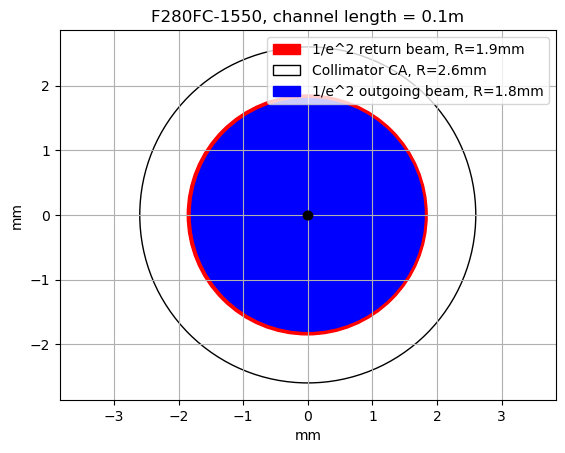

In [34]:
circle1 = plt.Circle((0, 0), e2Radius, color='b', label='1/e^2 outgoing beam, R=%.1fmm'%e2Radius)
circle2 = plt.Circle((-beamOffset, 0), returnBeamR, color='r', label='1/e^2 return beam, R=%.1fmm'%returnBeamR)
circle3 = plt.Circle((0, 0), CARadius, fill=False, label = 'Collimator CA, R=%.1fmm'%CARadius)

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

ax.add_patch(circle2)
ax.add_patch(circle3)
ax.add_patch(circle1)

plt.axis('equal')
plt.grid('on')
plt.legend()

plt.xlabel('mm')
plt.ylabel('mm')
plt.title('%s, channel length = %.1fm'%(model,channelLength/1000.))

plt.plot(0,0, 'o', color='black')
plt.plot(-beamOffset,0, 'o', color='black');

#fig.savefig('plotcircles.png')

### Let's do integration numerically

In [35]:
# for Gaussian beam:
#1/e2 half width: w = 2* sigma.
# fwhm = 2.355 * sigma
returnBeamSigma = returnBeamR/2.

map_max = np.ceil(beamOffset+map_Nsigma*returnBeamSigma)
map_min = -map_max
print(map_max)

4.0


In [36]:
nPixel = int((map_max - map_min)/pixelSize)
xVec = np.linspace(map_min, map_max, nPixel)
yVec = np.linspace(map_min, map_max, nPixel)
[x, y] = np.meshgrid(xVec, yVec)

z= np.exp(- ((x-(-beamOffset))**2+(y-0)**2)/2/returnBeamSigma**2 )

In [37]:
idx = x**2+y**2 < CARadius**2
idxCircle = (x**2+y**2 < CARadius**2+0.1) & (x**2+y**2 > CARadius**2-0.1)
idxe2 = (z > 0.134) & (z < 0.136)

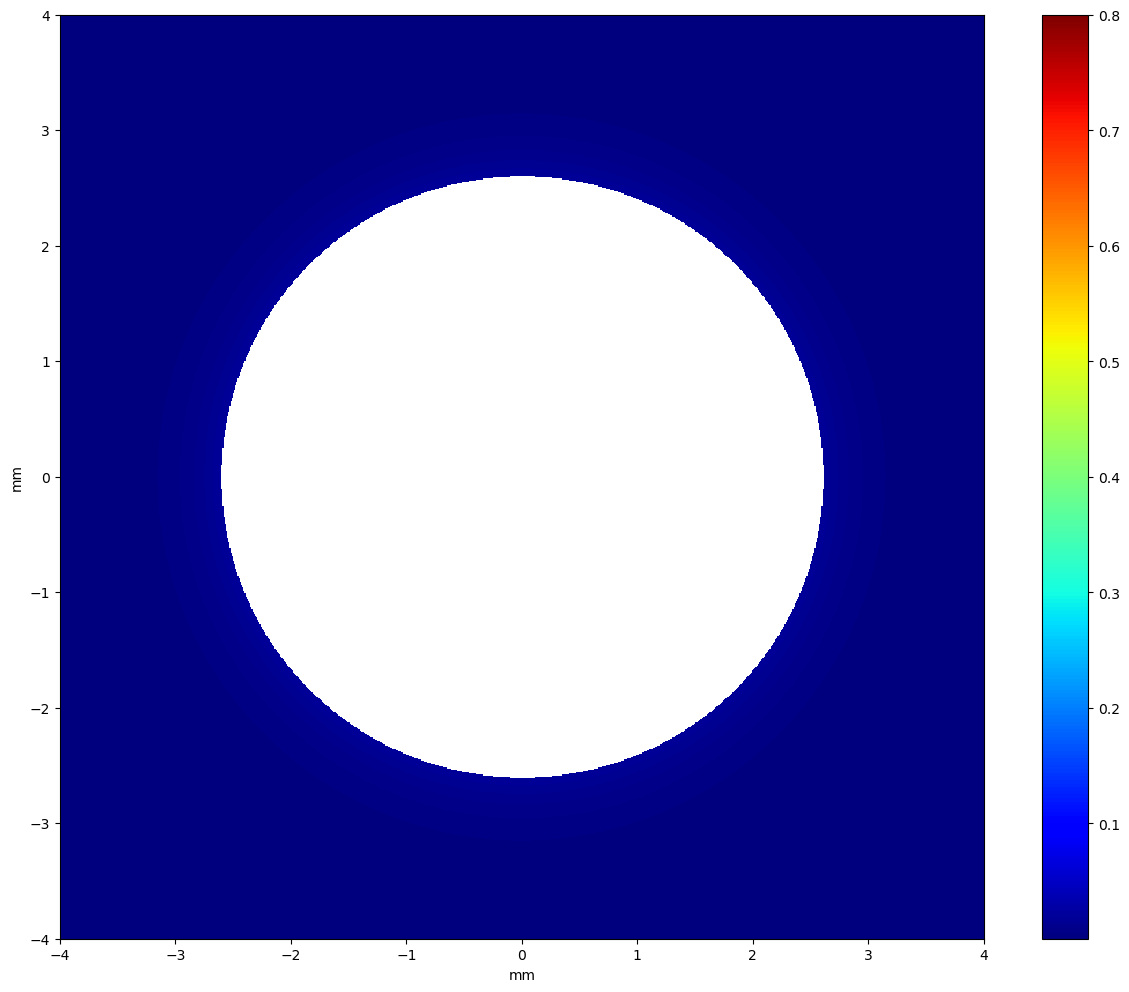

In [38]:
zplot = z.copy()
zplot[idx] = np.nan
zplot[idxe2]=0.8 #zplot[idxe2]+0.2
fig, ax = plt.subplots(1,1, figsize=(15,12))
plt.imshow(zplot, extent=[map_min, map_max, map_min, map_max])
plt.xlabel('mm')
plt.ylabel('mm')
plt.colorbar();

In [39]:
print(np.sum(z[idx])/np.sum(z))

0.9803060420057254


## Let's build a function to calculate the fraction of the returned energy so we can make a plot

In [40]:
#channelLength = 23000 #up to ~23 meters
#beamOffset = 7.0
def returnFraction(linetype, channelLength, beamOffset):
    if '280' in model: #M1-M1 channels
        CARadius = 2.6
        divAngle = 0.032 #deg
        e2Radius = 1.8 #mm
    elif '810' in model: #M1-M2 channels
        CARadius = 8.1
        divAngle = 0.016 #deg
        e2Radius = 3.5 #mm
    returnBeamR = e2Radius+np.radians(divAngle/2)*channelLength*2 #last factor of 2 is due to round trip
    #print(returnBeamR, beamOffset)
        
    # for Gaussian beam:
    #1/e2 half width: w = 2* sigma.
    # fwhm = 2.355 * sigma
    returnBeamSigma = returnBeamR/2.

    map_max = np.ceil(beamOffset+map_Nsigma*returnBeamSigma)
    map_min = -map_max
    
    nPixel = int((map_max - map_min)/pixelSize)
    xVec = np.linspace(map_min, map_max, nPixel)
    yVec = np.linspace(map_min, map_max, nPixel)
    [x, y] = np.meshgrid(xVec, yVec)

    z= np.exp(- ((x-(-beamOffset))**2+(y-0)**2)/2/returnBeamSigma**2 )
    
    idx = x**2+y**2 < CARadius**2
    return np.sum(z[idx])/np.sum(z)
frac = returnFraction(model, channelLength, beamOffset)
print(frac)
print(f2dB(frac))

0.9803060420057254
-0.08638320628743873


In [16]:
channelLength = 50 #2 inches
sep = np.arange(0, 10, 0.1)
frac = np.zeros(len(sep))
for i in range(len(sep)):
    frac[i] = returnFraction(model, channelLength, sep[i])

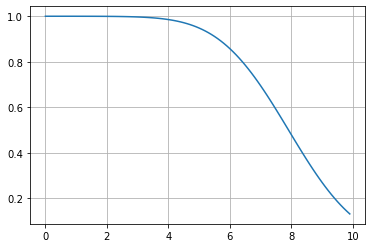

In [21]:
#fig, ax = plt.subplots(1,1, figsize=(15,12))
plt.plot(sep, frac)
plt.grid();

In [26]:
for i in range(len(sep)):
    print('%.2f, %.5f'%(sep[i], frac[i]))

0.00, 0.99999
0.10, 0.99999
0.20, 0.99998
0.30, 0.99998
0.40, 0.99998
0.50, 0.99998
0.60, 0.99998
0.70, 0.99997
0.80, 0.99997
0.90, 0.99996
1.00, 0.99992
1.10, 0.99990
1.20, 0.99988
1.30, 0.99986
1.40, 0.99983
1.50, 0.99980
1.60, 0.99976
1.70, 0.99970
1.80, 0.99964
1.90, 0.99957
2.00, 0.99945
2.10, 0.99934
2.20, 0.99921
2.30, 0.99906
2.40, 0.99887
2.50, 0.99865
2.60, 0.99840
2.70, 0.99810
2.80, 0.99774
2.90, 0.99733
3.00, 0.99682
3.10, 0.99625
3.20, 0.99560
3.30, 0.99484
3.40, 0.99397
3.50, 0.99297
3.60, 0.99182
3.70, 0.99051
3.80, 0.98902
3.90, 0.98733
4.00, 0.98538
4.10, 0.98321
4.20, 0.98076
4.30, 0.97802
4.40, 0.97495
4.50, 0.97153
4.60, 0.96772
4.70, 0.96350
4.80, 0.95884
4.90, 0.95370
5.00, 0.94803
5.10, 0.94184
5.20, 0.93509
5.30, 0.92773
5.40, 0.91975
5.50, 0.91111
5.60, 0.90180
5.70, 0.89178
5.80, 0.88105
5.90, 0.86958
6.00, 0.85733
6.10, 0.84436
6.20, 0.83062
6.30, 0.81611
6.40, 0.80086
6.50, 0.78486
6.60, 0.76813
6.70, 0.75070
6.80, 0.73259
6.90, 0.71383
7.00, 0.69445
7.10, 